# PPC

die methode heißt posterior predictive checking - sprich man nimmt parameter aus der posterior distribution und simuliert damit dann daten. ist an sich eine methode zum model checking. Ich machs zum Beispiel um zu checken ob unsere Hintergrundmodell für GBM fähig ist, die Lichtkurve zu erklären.

Das Beispiel ist jetzt im Falle von nem GRB und wichtig ich falte hier gerade nicht durch die Response, sondern erzeug nur nen Plot in dem man das 95% confidence band sieht


Mehr zu PPC findest du in Björns PhD thesis

In [38]:
import sys, os
sys.path.insert(0, os.path.abspath('/home/tguethle/Documents/spi/Master_Thesis/main_files'))


import numpy as np
import astropy.io.fits as fits
from astropy.table import Table
from astromodels import Powerlaw, PointSource, SpectralComponent
import astropy.time as at
from datetime import datetime
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
from MultinestClusterFit import powerlaw_binned_spectrum, MultinestClusterFit
from RebinningFunctions import spimodfit_binning_SE, log_binning_function_for_x_number_of_bins, no_rebinning #, rebin_data_exp_50
from PointingClusters import PointingClusters, save_clusters, load_clusters
from ModelSources import *
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
from chainconsumer import ChainConsumer
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [78]:

def confidence_ellipse(val, cov, ax, n_std=1.0, facecolor='none', **kwargs):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    

    eig = np.linalg.eig(cov)
    
    # Calculating the standard deviation of x from

    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = val[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = val[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [79]:
x = 1
print(id(x))
def test(temp=x):
    return temp

x = 2

a = test()

print(id(a))
print(id(x))

140365715462448
140365715462448
140365715462480


In [80]:
var1 = 1
var2 = 1

print(id(var1), id(var2))
var2 = 2
print(id(var1), id(var2))

140365715462448 140365715462448
140365715462448 140365715462480


[0.0007001161122881636, -1.9983662972152607]

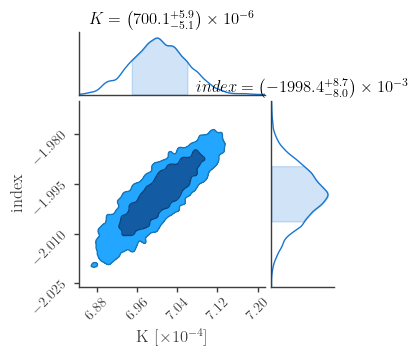

In [81]:
# chain = np.loadtxt("1-post_equal_weights.dat")
chain = np.loadtxt("chain_correct.dat")
c = ChainConsumer()
c.add_chain(chain[:,:-1],parameters=["K","index"],posterior=chain[:,-1])
# c.configure(sigmas=[1,2])
c.plotter.plot()

vals = c.analysis.get_summary()

p=["K", "index"]
val = np.array([i[1] for i in c.analysis.get_summary(parameters=p).values()])
cov = c.analysis.get_covariance(parameters=p)[1]
    

mean_vals = [vals["K"][1], vals["index"][1]]
mean_vals

In [82]:
t = c.analysis.get_latex_table()
print(t)

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccc}
        \hline
		Model & K & index \\ 
		\hline
		Chain 0 & $\left( 700.1^{+5.9}_{-5.1} \right) \times 10^{-6}$ & $\left( -1998.4^{+8.7}_{-8.0} \right) \times 10^{-3}$ \\ 
		\hline
    \end{tabular}
\end{table}


'\\begin{table}\n    \\centering\n    \\caption{}\n    \\label{tab:model_params}\n    \\begin{tabular}{ccc}\n        \\hline\n\t\tModel & K & index \\\\ \n\t\t\\hline\n\t\tChain 0 & $\\left( 700.1^{+5.9}_{-5.1} \\right) \\times 10^{-6}$ & $\\left( -1998.4^{+8.7}_{-8.0} \\right) \\times 10^{-3}$ \\\\ \n\t\t\\hline\n    \\end{tabular}\n\\end{table}'


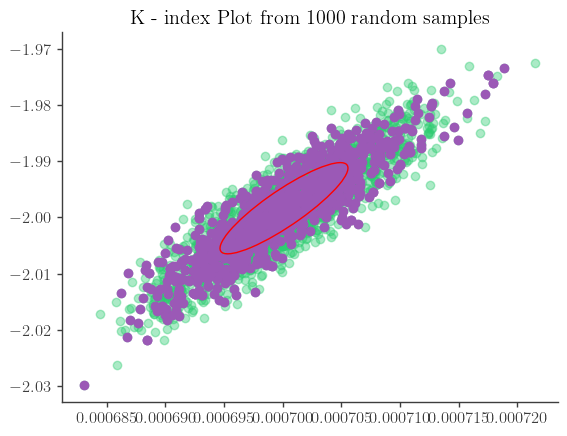

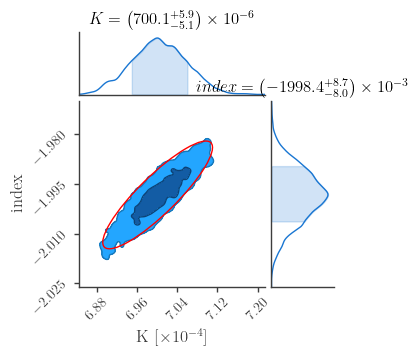

In [83]:
%matplotlib inline
# ich zieh mir 1000 samples aus der posterior distribution - vergleichs obs ähnlich zum corner plot ist
nsamples = 1000
rnd_samples = np.random.randint(len(chain[:,0]),size = nsamples)


fig, ax = plt.subplots()
ax.set_title(f"K - index Plot from {nsamples} random samples")
ax.scatter(chain[rnd_samples,0],chain[rnd_samples,1], zorder=10)
ax.scatter(chain[:,0],chain[:,1],alpha=0.4)

confidence_ellipse(val, cov, ax, n_std=1, edgecolor='red', zorder=20)

c.configure(sigmas=[1,2], sigma2d=True)
fig = c.plotter.plot()

ax_chainconsumer = fig.axes[2]
confidence_ellipse(val, cov, ax_chainconsumer, n_std=2, edgecolor='red', zorder=20)


## For single pointing

In [6]:
# define constants for the response folding. all with the band model
pointing_id = 0
emod = np.geomspace(20, 1000, 100)
ra, dec = 10, -40
orig_data_path = '/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center'


# load the data from the base data files
# Energy Bins
with fits.open(f"{orig_data_path}/energy_boundaries.fits") as file:

    t = Table.read(file[1])
    energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    print(f'Number of energy bins: {len(energy_bins)-1}')
# Pointings and Start Times
with fits.open(f"{orig_data_path}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings = np.array(t["PTID_SPI"])
    
    time_start = np.array(t["TSTART"]) + 2451544.5
    time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
    time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])


# Time Elapsed
# det=i, pointing_index=j : index = j*85 + i
with fits.open(f"{orig_data_path}/dead_time.fits") as file:
    
    t = Table.read(file[1])
    time_elapsed = np.array(t["LIVETIME"])

# Generate Source Counts

assert find_response_version(time_start[0]) == find_response_version(time_start[-1]), "Versions not constant"
version = find_response_version(time_start[0])
rsp_base = ResponseDataRMF.from_version(version)

time = time_start[pointing_id]
dets = get_live_dets(time=time, event_types=["single"])

rmfs = []
for d in dets:
    rmfs.append(ResponseRMFGenerator.from_time(time, d, energy_bins, emod, rsp_base))
    
sds = np.empty(0)
for d in range(len(dets)):
    sd = SPIDRM(rmfs[d], ra, dec)
    sds = np.append(sds, sd.matrix.T)
resp_mat = sds.reshape((len(dets), len(emod)-1, len(energy_bins)-1))

# all above is the same for one single pointing. the only thing that changes are the parameters


def fold_respose(parameter, piv=100):
    K, index_pl = parameter
    # define the source
    pl = Powerlaw()
    pl.piv = piv
    pl.K = K
    pl.index = index_pl
    component1 = SpectralComponent("pl", shape=pl)
    source = PointSource("Test", ra=ra, dec=dec, components=[component1])

    spec_binned = powerlaw_binned_spectrum(emod, source(emod))

    count_rates = np.dot(spec_binned, resp_mat)
    source_counts_poisson = np.zeros((19, len(energy_bins)-1), dtype=np.uint32)
    source_counts = np.zeros((19, len(energy_bins)-1), dtype=np.uint32)

    for d_i, d in enumerate(dets):
        index = pointing_id * 85 + d
        source_counts[d] = count_rates[d_i,:] * time_elapsed[index]
        source_counts_poisson[d] = np.random.poisson(count_rates[d_i,:] * time_elapsed[index])

    return source_counts, source_counts_poisson




Number of energy bins: 41
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)


In [116]:
chain.shape

(2816, 3)

In [11]:
# ich falte das jetzt nicht durch die response sondern lass mir nur die functions werte ausgeben

e = np.geomspace(3,5000,1000)


vals = np.zeros((nsamples,19,len(energy_bins)-1))
vals_poisson = np.zeros((nsamples,19,len(energy_bins)-1))
for n, rnd_sample in enumerate(rnd_samples):
    # hier müsstest dus dann durch die response falten, sprich zwischen den input energies integrieren und mit der response multiplizieren

    vals[n], vals_poisson[n] = fold_respose(chain[rnd_sample,:2])
    
    print(f"Sample {n}/1000 done")
temp2 = fold_respose(mean_vals)
mean_val = temp2[0]
mean_val_poisson = temp2[1]


Sample 0/1000 done
Sample 1/1000 done
Sample 2/1000 done
Sample 3/1000 done
Sample 4/1000 done
Sample 5/1000 done
Sample 6/1000 done
Sample 7/1000 done
Sample 8/1000 done
Sample 9/1000 done
Sample 10/1000 done
Sample 11/1000 done
Sample 12/1000 done
Sample 13/1000 done
Sample 14/1000 done
Sample 15/1000 done
Sample 16/1000 done
Sample 17/1000 done
Sample 18/1000 done
Sample 19/1000 done
Sample 20/1000 done
Sample 21/1000 done
Sample 22/1000 done
Sample 23/1000 done
Sample 24/1000 done
Sample 25/1000 done
Sample 26/1000 done
Sample 27/1000 done
Sample 28/1000 done
Sample 29/1000 done
Sample 30/1000 done
Sample 31/1000 done
Sample 32/1000 done
Sample 33/1000 done
Sample 34/1000 done
Sample 35/1000 done
Sample 36/1000 done
Sample 37/1000 done
Sample 38/1000 done
Sample 39/1000 done
Sample 40/1000 done
Sample 41/1000 done
Sample 42/1000 done
Sample 43/1000 done
Sample 44/1000 done
Sample 45/1000 done
Sample 46/1000 done
Sample 47/1000 done
Sample 48/1000 done
Sample 49/1000 done
Sample 50/

## For the sum of several pointings

In [108]:
vals = np.zeros((nsamples,19,len(energy_bins)-1))
vals_poisson = np.zeros((nsamples,19,len(energy_bins)-1))
mean_val, mean_val_poisson = 0, 0

for pointing_id in (0,5,10,15,20,25,30):
    print(f"Gen data for pointing {pointing_id}")

    emod = np.geomspace(20, 1000, 100)
    ra, dec = 10, -40
    orig_data_path = '/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center'


    # load the data from the base data files
    # Energy Bins
    with fits.open(f"{orig_data_path}/energy_boundaries.fits") as file:

        t = Table.read(file[1])
        energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
        print(f'Number of energy bins: {len(energy_bins)-1}')
    # Pointings and Start Times
    with fits.open(f"{orig_data_path}/pointing.fits") as file:
        t = Table.read(file[1])
        
        pointings = np.array(t["PTID_SPI"])
        
        time_start = np.array(t["TSTART"]) + 2451544.5
        time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
        time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])


    # Time Elapsed
    # det=i, pointing_index=j : index = j*85 + i
    with fits.open(f"{orig_data_path}/dead_time.fits") as file:
        
        t = Table.read(file[1])
        time_elapsed = np.array(t["LIVETIME"])

    # Generate Source Counts

    assert find_response_version(time_start[0]) == find_response_version(time_start[-1]), "Versions not constant"
    version = find_response_version(time_start[0])
    rsp_base = ResponseDataRMF.from_version(version)

    time = time_start[pointing_id]
    dets = get_live_dets(time=time, event_types=["single"])

    rmfs = []
    for d in dets:
        rmfs.append(ResponseRMFGenerator.from_time(time, d, energy_bins, emod, rsp_base))
        
    sds = np.empty(0)
    for d in range(len(dets)):
        sd = SPIDRM(rmfs[d], ra, dec)
        sds = np.append(sds, sd.matrix.T)
    resp_mat = sds.reshape((len(dets), len(emod)-1, len(energy_bins)-1))

    # all above is the same for one single pointing. the only thing that changes are the parameters


    def fold_respose(parameter, piv=100):
        K, index_pl = parameter
        # define the source
        pl = Powerlaw()
        pl.piv = piv
        pl.K = K
        pl.index = index_pl
        component1 = SpectralComponent("pl", shape=pl)
        source = PointSource("Test", ra=ra, dec=dec, components=[component1])

        spec_binned = powerlaw_binned_spectrum(emod, source(emod))

        count_rates = np.dot(spec_binned, resp_mat)
        source_counts_poisson = np.zeros((19, len(energy_bins)-1), dtype=np.uint32)
        source_counts = np.zeros((19, len(energy_bins)-1), dtype=np.uint32)

        for d_i, d in enumerate(dets):
            index = pointing_id * 85 + d
            source_counts[d] = count_rates[d_i,:] * time_elapsed[index]
            source_counts_poisson[d] = np.random.poisson(count_rates[d_i,:] * time_elapsed[index])

        return source_counts, source_counts_poisson

    for n, rnd_sample in enumerate(rnd_samples):
       
        temp = fold_respose(chain[rnd_sample,:2])
    
        vals[n] += temp[0]
        vals_poisson[n] += temp[1]
        
        print(f"Sample {n}/1000 done")

    temp2 = fold_respose(mean_vals)
    mean_val += temp2[0]
    mean_val_poisson += temp2[1]


Gen data for pointing 0
Number of energy bins: 41
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
Sample 0/1000 done
Sample 1/1000 done
Sample 2/1000 done
Sample 3/1000 done
Sample 4/1000 done
Sample 5/1000 done
Sample 6/1000 done
Sample 7/1000 done
Sample 8/1000 done
Sample 9/1000 done
Sample 10/1000 done
Sample 11/1000 done
Sample 12/1000 done
Sample 13/1000 done
Sample 14/1000 done
Sample 15/1000 done
Sample 16/1000 done
Sample 17/1000 done
Sample 18/1000 done
Sample 19/1000 done
Sample 20/1000 done
Sample 21/1000 done
Sample 22/1000 done
Sample 23/1000 done
Sample 24/1000 done
Sample 25/1000 done
Sample 26/1000 done
Sample 27/1000 done
Sample 28/1000 done
Sample 29/1000 done
Sample 30/1000 done
Sample 31/1000 done
Sample 32/1000 done
Sample 33/1000 done
Sample 34/1000 done
Sample 35/1000 done
Sample 36/1000 done
Sample 37/1000 done
Sample 38/1000 done
Sample 39/1000 done
Sample 40/1000 done
Sample 41/1000 done
Sample 42/1000 done
Sa

In [104]:
vals[0,:,0]

array([363., 297.,   0., 504., 478., 520., 355., 271., 327., 496., 538.,
       412., 521., 709., 585., 460., 558.,   0., 350.])

## Spimodfit data

In [12]:
# take a look at the response of spimodfit
spimodfit_path_1160 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_bright_100_small_bins/"
spimodfit_path_41 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_normal_new/"

response_name = "convolved_sky_images.fits"

with fits.open(spimodfit_path_41 + response_name) as hdul:
    t = Table(hdul[2].data)
    header = hdul[2].header
    t2 = Table(hdul[1].data)
counts_41 = t["COUNTS"]
err_41_low_K = np.array(t["STAT_ERR"])



spimodfit_counts_41_low_K = np.array(counts_41)

In [32]:

smf = spimodfit_counts_41_low_K[(pointing_id * 19):(pointing_id +1) * 19]
smf_normal = smf / np.nanmean(smf, axis=0)

smf_err = err_41_low_K[(pointing_id * 19):(pointing_id +1) * 19]
smf_err_normal = smf_err / np.nanmean(smf, axis=0)

## Plot

In [14]:
# das sind ist das 95% interval
min_val = np.percentile(vals, 2.5, axis=0)
max_val = np.percentile(vals, 97.5, axis=0)
min_val_poisson = np.percentile(vals_poisson, 2.5, axis=0)
max_val_poisson = np.percentile(vals_poisson, 97.5, axis=0)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

min_val_normal, max_val_normal = min_val / np.nanmean(min_val, axis=0), max_val / np.nanmean(max_val, axis=0)
min_val_poisson_normal, max_val_poisson_normal = min_val_poisson / np.nanmean(min_val_poisson, axis=0), max_val_poisson / np.nanmean(max_val_poisson, axis=0)


mean_val_normal = mean_val / np.nanmean(mean_val, axis=0)
mean_val_poisson_normal = mean_val_poisson / np.nanmean(mean_val_poisson, axis=0)


WARNING RuntimeWarning: invalid value encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



In [119]:
min_val[:,0]

array([31.,  8.,  0., 32., 32., 26., 31.,  5.,  8.,  8., 15.,  9., 31.,
       25., 10., 25., 17.,  0.,  9.])

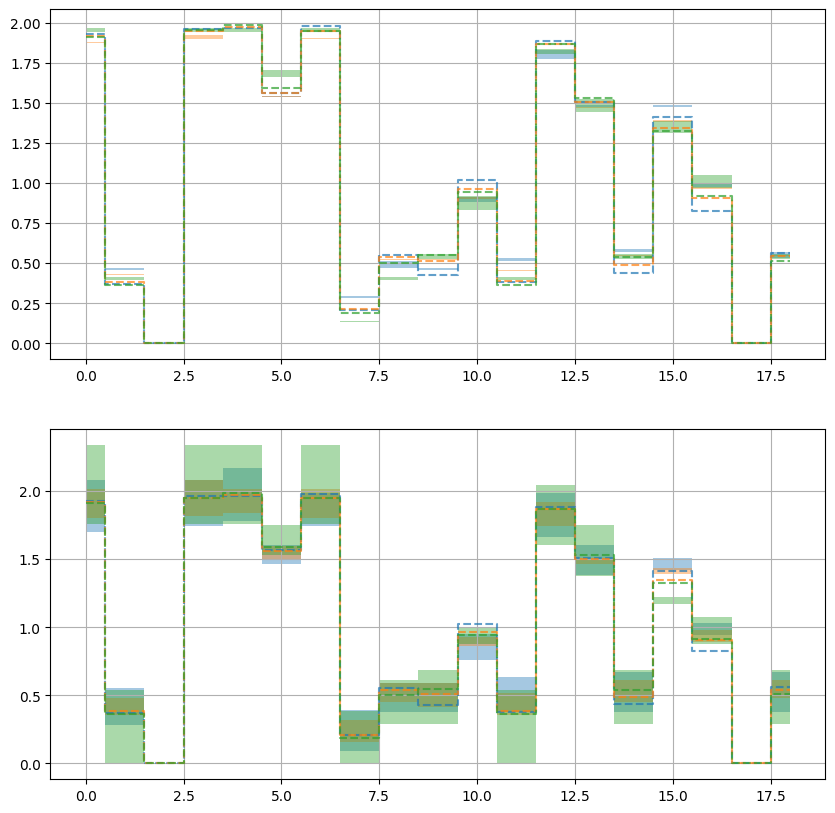

In [130]:
%matplotlib inline

fig, (ax,ax2) = plt.subplots(2,1, figsize=(10,10))



x_det = np.arange(0,19)

used_bins = (0,10,30,)

ax.grid()
ax2.grid()

for bin in used_bins:
    ax.fill_between(x_det, min_val_normal[:,bin], max_val_normal[:,bin], alpha=0.4, step="mid", label=f"Energy Bin {bin}")
    # ax.step(x_det, mean_val_normal[:,bin], where="mid")
    # ax2.fill_between(x_det, min_val_poisson_normal[:,bin], max_val_poisson_normal[:,bin], alpha=0.4, step="mid", label=f"Energy Bin {bin}")
    # ax2.step(x_det, mean_val_normal[:,bin], where="mid")
    # ax.step(x_det, max_val_normal[:,bin], where="mid", alpha=0.99, linestyle="--")
    ax.step(x_det, smf_normal[:,bin], where="mid", label=f"Energy Bin {bin}", linestyle="--", alpha=0.7)
    ax2.step(x_det, smf_normal[:,bin], where="mid", label=f"Energy Bin {bin}", linestyle="--", alpha=0.7)


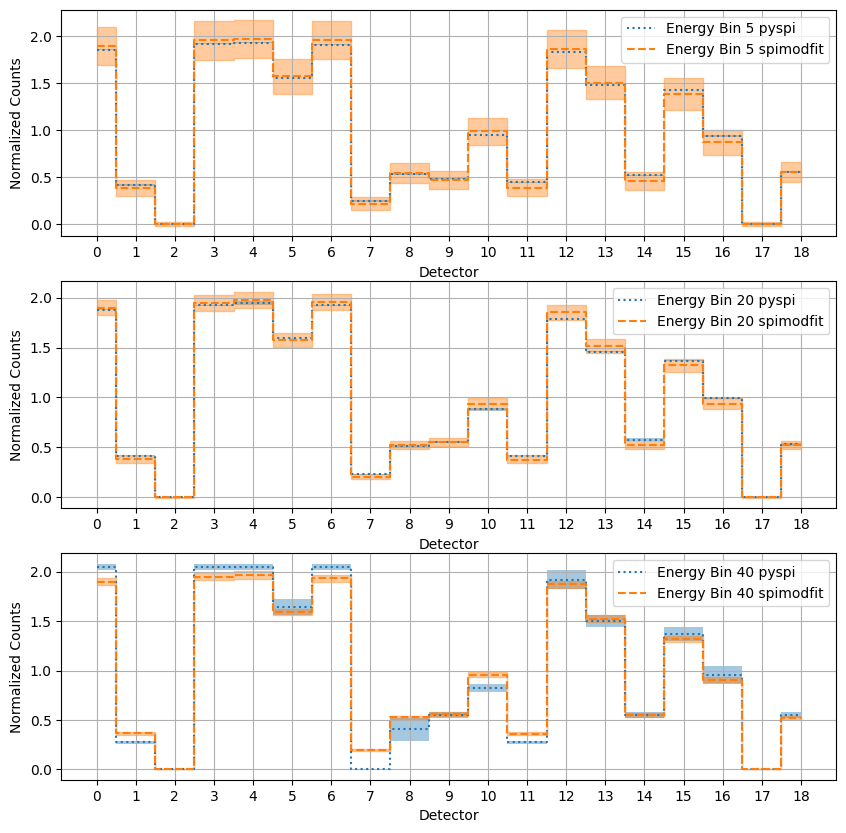

In [41]:
%matplotlib inline
fig, ax = plt.subplots(3,1, figsize=(10,10))

x_det = np.arange(0,19)

used_bins1 = (5,20,40)



mean2 = (min_val_normal + max_val_normal) / 2



for i, bin in enumerate(used_bins1):
    ax[i].fill_between(x_det, min_val_normal[:,bin], max_val_normal[:,bin], alpha=0.4, step="mid",)
    ax[i].fill_between(x_det, smf_normal[:,bin] - smf_err_normal[:,bin], smf_normal[:,bin] + smf_err_normal[:,bin], alpha=0.4, step="mid", color="C1")
    ax[i].step(x_det, mean2[:,bin], where="mid", label=f"Energy Bin {bin} pyspi", linestyle=":", color="C0")
    ax[i].step(x_det, smf_normal[:,bin], where="mid", label=f"Energy Bin {bin} spimodfit", linestyle="--", color="C1")
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xticks(x_det)
    ax[i].set_ylabel("Normalized Counts")
    ax[i].set_xlabel("Detector")




In [42]:
fig.savefig("convolved_counts.pdf")

In [35]:
np.nanmean(mean_val, axis=0)


array([17.47368421, 23.63157895, 27.73684211, 32.42105263, 42.94736842,
       38.73684211, 44.31578947, 40.84210526, 45.10526316, 41.10526316,
       37.89473684, 42.05263158, 39.31578947, 36.52631579, 34.84210526,
       32.47368421, 31.05263158, 28.73684211, 26.84210526, 26.47368421,
       19.94736842, 20.78947368, 19.47368421, 15.47368421, 16.05263158,
       16.        , 12.47368421, 12.47368421,  9.94736842,  9.78947368,
        8.73684211,  7.10526316,  5.63157895,  4.73684211,  4.05263158,
        3.36842105,  3.21052632,  3.47368421,  2.63157895,  0.31578947,
        3.52631579])

In [86]:
print(min_val_normal[:,-1])
print(max_val_normal[:,-1])

print(min_val[:,0])
print(max_val[:,0])

[1.91778393 0.38919709 0.         1.95138376 1.90917494 1.63427469
 1.95422705 0.20408905 0.50422935 0.56235868 0.92807459 0.3904221
 1.79224556 1.47145981 0.56423368 1.301896   0.97241591 0.
 0.55253381]
[1.91787743 0.38929137 0.         1.95141233 1.90896326 1.63444001
 1.9543139  0.20411781 0.50415514 0.56235741 0.92796978 0.3905255
 1.79193623 1.47125289 0.56428399 1.30180742 0.97265195 0.
 0.55264359]
[31.6655313   8.28993768  0.         32.48566771 32.70443302 26.67537355
 31.89238177  5.10958557  8.89895966  8.59970144 15.77182722  9.06132268
 31.17121336 25.52023736 10.46983335 25.49175546 17.5737111   0.
  9.95141221]
[32.08466819  8.39800691  0.         32.9147306  33.13854906 27.02591992
 32.31442049  5.17654072  9.01785194  8.71019273 15.98333022  9.17921848
 31.58585682 25.85914059 10.60429518 25.82979592 17.79678551  0.
 10.0832604 ]
